# Binary Image Classification

In [1]:
# The images could be grayscale w./ one channel
# or color image w./ three channels

Histopathologic Cancer Detection on Kaggle

In [3]:
import pandas as pd

labels_df = pd.read_csv('C:/Users/timsh/Desktop/data/train_labels.csv')
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


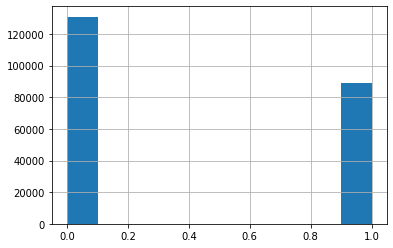

In [6]:
%matplotlib inline
labels_df['label'].hist()

In [7]:
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os

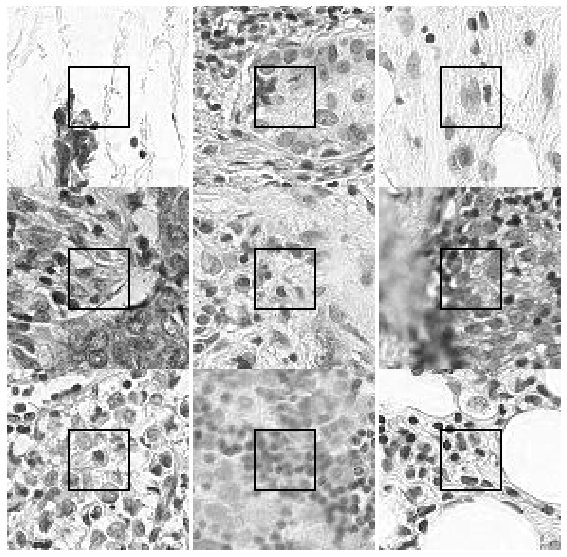

In [8]:
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

path2train = 'C:/Users/timsh/Desktop/data/train/'
color = False

plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols=3,3

for i, id_ in enumerate(malignantIds[:nrows*ncols]):
    full_filenames = os.path.join(path2train, id_ + '.tif')
    
    img = Image.open(full_filenames)
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32,32),(64,64)), outline='green')
    plt.subplot(nrows,ncols,i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap='gray')
    plt.axis('off')

In [9]:
print('image shape:', np.array(img).shape)
print('pixel values range from %s to %s' %(np.min(img),np.max(img)))

image shape: (96, 96, 3)
pixel values range from 0 to 255


In [10]:
# Creating a PyTorch custom dataset: __len__ & __getitem__
# to save RAM

import torch
from torch.utils.data import Dataset  # as the base class of custom dataset
import torchvision.transforms as transforms

torch.manual_seed(0)

In [11]:
class histoCancerDataset(Dataset):
    def __init__(self,data_dir,transform,data_type='train'):
        path2data = os.path.join(data_dir,data_type)
        filenames = os.listdir(path2data)
        self.full_filenames = [os.path.join(path2data,f) for f in filenames]
        csv_filename=data_type+'_labels.csv'
        path2csvLabels=os.path.join(data_dir,csv_filename)
        labels_df=pd.read_csv(path2csvLabels)
        labels_df.set_index('id',inplace=True)
        self.labels = [labels_df.loc[filename[:-4]].values[0] for 
                       filename in filenames]
        self.transform = transform
    
    def __len__(self):
        return len(self.full_filenames)
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        return image, self.labels[idx]

In [12]:
data_transformer = transforms.Compose([transforms.ToTensor()])
data_dir = 'C:/Users/timsh/Desktop/data/'
histo_dataset = histoCancerDataset(data_dir,data_transformer, 'train')
print(len(histo_dataset))

220025


In [13]:
img, label = histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


# Splitting the dataset

In [14]:
# split the dataset into training and validation

In [15]:
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo - len_train

train_ds,val_ds = random_split(histo_dataset,[len_train,len_val])

print('train dataset length:', len(train_ds))
print('validation dataset length:', len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [16]:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [17]:
import matplotlib.pyplot as plt
np.random.seed(0)

In [18]:
# define a helper func. to show an image

def show(img,y,color=False):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg,(1,2,0))
    if color == False:
        npimg_tr = npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap='gray')
    else:
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title('label: '+str(y))

image indices: [ 95939  97639  41993 122579]
torch.Size([3, 100, 394])


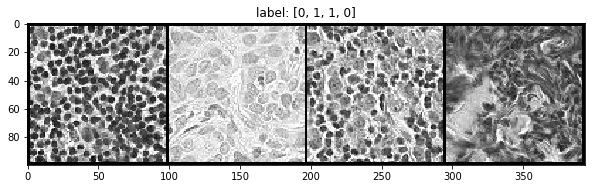

In [20]:
# create a grid of sample images from train_ds
from torchvision import utils

grid_size = 4
rnd_inds = np.random.randint(0,len(train_ds),grid_size)
print('image indices:', rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train,nrow=4,padding=2)
print(x_grid_train.shape)
plt.rcParams['figure.figsize'] = (10.0,5)
show(x_grid_train,y_grid_train)

# Transforming the data

In [21]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor()
])

In [22]:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [23]:
train_ds.transform = train_transformer
val_ds.transform = val_transformer

# Creating dataloaders

In [24]:
# PyTorch dataloader helps auto-loop over datasets and extract a data batch

In [25]:
from torch.utils.data import DataLoader

# the batch size determines the number of images to be extracted from the
# dataset in each iteration (typically in the range of 8-128)
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True)
val_dl = DataLoader(val_ds,batch_size=64,shuffle=False)

# Building the classification model

FOUR CNNs + TWO fully connected layers

after each convolutional layer, there is a pooling layer

In [26]:
# dumb baselines for the validation dataset w./ all-zero predictions
y_val = [y for _, y in val_ds] # get labels for validation dataset

def accuracy(labels,out):
    return np.sum(out==labels)/float(len(labels))

acc_all_zeros = accuracy(y_val,np.zeros_like(y_val))
print('accuracy all zero prediction: %.2f' %acc_all_zeros)

accuracy all zero prediction: 0.59


In [27]:
import torch.nn as nn

In [28]:
# auto-compute the output size of a CNN and pooling layer
def findConv2dOutShape(H_in,W_in,conv,pool=2):
    kernel_size = conv.kernel_size
    stride = conv.stride
    padding = conv.padding
    dilation = conv.dilation
    # formula to compute the output size
    H_out = np.floor((H_in+2*padding[0]-
                      dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out = np.floor((W_in+2*padding[1]-
                     dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        H_out/=pool
        W_out/=pool
    return int(H_out),int(W_out)

In [29]:
#e.g.
conv1 = nn.Conv2d(3,8,kernel_size=3)
h,w = findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [30]:
import torch.nn.functional as F

In [33]:
class Net(nn.Module):
    def __init__(self,params):
        super(Net,self).__init__()
        C_in,H_in,W_in = params['input_shape']
        init_f = params['initial_filters']
        num_fc1 = params['num_fc1']
        num_classes = params['num_classes']
        self.dropout_rate = params['dropout_rate']
        
        self.conv1 = nn.Conv2d(C_in,init_f,kernel_size=3)
        h,w = findConv2dOutShape(H_in,W_in,self.conv1)
        self.conv2 = nn.Conv2d(init_f,2*init_f,kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv2)
        self.conv3 = nn.Conv2d(2*init_f,4*init_f,kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv3)
        self.conv4 = nn.Conv2d(4*init_f,8*init_f,kernel_size=3)
        h,w = findConv2dOutShape(h,w,self.conv4)
        
        self.num_flatten = h*w*8*init_f # output size of the 4th CNN layer
        self.fc1 = nn.Linear(self.num_flatten,num_fc1)
        self.fc2 = nn.Linear(num_fc1,num_classes)
        
    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2,2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x,2,2)
        x = x.view(-1,self.num_flatten) # reshape 4D tensor to 2D
        x = F.relu(self.fc1(x)) # linear layer accepts 2D tensor
        x = F.dropout(x,self.dropout_rate,training=self.training) #overfitting
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [34]:
params_model = {
    'input_shape': (3,96,96),
    'initial_filters':8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes':2,
}

cnn_model = Net(params_model)

device = torch.device('cuda')
cnn_model = cnn_model.to(device)

print(cnn_model)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


# Defining the loss function

In [35]:
loss_func = nn.NLLLoss(reduction='sum') # sum of loss values per batch of data

torch.manual_seed(0)

#e.g.
n,c=8,2 # 8 samples w./ 2 classes
y = torch.randn(n,c,requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out = ls_F(y)
print (y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out,target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [36]:
loss.backward()
print(y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining the optimizer

In [37]:
from torch import optim
opt = optim.Adam(cnn_model.parameters(),lr=3e-4)

In [38]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# defining learning rate scheduler
# if no improvement is seen for a patience number of epochs, the learning rate
# is reduced by a factor of 0.5
# if we monitor the loss value, we set mode = 'min'
# if we monitor the accuracy, we set mode = 'max'
lr_scheduler = ReduceLROnPlateau(opt,mode='min',
                                 factor=0.5,patience=20,verbose=1)

In [42]:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

# Training and evaluation of the model

In [39]:
def metrics_batch(output,target):
    pred = output.argmax(dim=1,keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [40]:
def loss_batch(loss_func,output,target,opt=None):
    loss = loss_func(output,target)
    with torch.no_grad():
        metric_b = metrics_batch(output,target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item(), metric_b

In [41]:
def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)
    
    for xb,yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)
        loss_b,metric_b = loss_batch(loss_func,output,yb,opt)
        
        running_loss+=loss_b
        if metric_b is not None:
            running_metric += metric_b
        
        if sanity_check is True:
            break
    loss=running_loss/float(len_data)
    metric = running_metric/float(len_data)
    return loss, metric

In [47]:
def train_val(model,params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']
    
    loss_history={'train':[],'val':[],}
    metric_history={'train':[],'val':[],}
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch,num_epochs-1,
                                                 current_lr))
        model.train()
        train_loss,train_metric=loss_epoch(model,loss_func,
                                           train_dl,sanity_check,opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)
        
        model.eval()
        with torch.no_grad():
            val_loss,val_metric = loss_epoch(model,loss_func,val_dl,sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts=copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(),path2weights)
            print('Copied best model weights!')
        
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)
            
        print('train loss: %.6f, dev loss: %.6f, accuracy: %.2f'
             %(train_loss, val_loss, 100*val_metric))
        print('-'*10)
        
    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [49]:
import copy
loss_func = nn.NLLLoss(reduction='sum')
opt = optim.Adam(cnn_model.parameters(),lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt,mode='min',factor=0.5,patience=20,
                                 verbose=1)

params_train={
    'num_epochs':10,
    'optimizer': opt,
    'loss_func': loss_func,
    'train_dl': train_dl,
    'val_dl': val_dl,
    'sanity_check': False,
    'lr_scheduler': lr_scheduler,
    'path2weights': 'C:/Users/timsh/weights.pt',
}

cnn_model,loss_hist,metric_hist = train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.457784, dev loss: 0.419706, accuracy: 81.72
----------
Epoch 1/99, current lr=0.0003
Copied best model weights!
train loss: 0.387358, dev loss: 0.378891, accuracy: 83.02
----------
Epoch 2/99, current lr=0.0003
Copied best model weights!
train loss: 0.351214, dev loss: 0.331168, accuracy: 85.67
----------
Epoch 3/99, current lr=0.0003
Copied best model weights!
train loss: 0.329876, dev loss: 0.314101, accuracy: 86.76
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 0.310751, dev loss: 0.295703, accuracy: 87.76
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 0.295240, dev loss: 0.294037, accuracy: 87.78
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 0.282244, dev loss: 0.285224, accuracy: 88.14
----------
Epoch 7/99, current lr=0.0003
Copied best model weights!
train loss: 0.270095, dev loss: 0.262103, accuracy: 89.20
---

KeyboardInterrupt: 

In [60]:
# initially set num_epochs=100, then interrupt the kernel after 10 rounds

# Deploying the model

In [50]:
params_model = {
    'input_shape': (3,96,96),
    'initial_filters':8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2,
}

cnn_model = Net(params_model)

In [51]:
path2weights= 'C:/Users/timsh/weights.pt'
cnn_model.load_state_dict(torch.load(path2weights))

In [52]:
cnn_model.eval() # for deployment, it's necessary to set the model in eval mode

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [57]:
import time

def deploy_model(model,dataset,device,num_classes=2,sanity_check=False):
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) # model outputs
    y_gt=np.zeros((len_data),dtype='uint8') # ground truth labels
    model = model.to(device)
    
    elapsed_times=[]
    with torch.no_grad():
        for i in range(len_data):
            x,y=dataset[i]
            y_gt[i]=y
            start=time.time()
            y_out[i]=model(x.unsqueeze(0).to(device))
            elapsed=time.time() -start
            elapsed_times.append(elapsed)
            if sanity_check is True:
                break
    inference_time = np.mean(elapsed_times)*1000
    print('average inference time per image on %s: %.2f ms'
         %(device,inference_time))
    return y_out.numpy(), y_gt

In [58]:
y_out,y_gt = deploy_model(cnn_model,val_ds,device=device,sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 1.37 ms
(44005, 2) (44005,)


In [59]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

acc = accuracy_score(y_pred,y_gt)
print('accuracy: %.2f' %acc)

(44005,) (44005,)
accuracy: 0.90


# Model inference on test data

In [61]:
path2csv = 'C:/Users/timsh/Desktop/data/test_labels.csv'
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


In [63]:
histo_test = histoCancerDataset(data_dir,val_transformer,data_type='test')
print(len(histo_test))

57458


In [64]:
y_test_out,_=deploy_model(cnn_model,histo_test,device,sanity_check=False)

average inference time per image on cuda: 1.66 ms


In [65]:
y_test_pred=np.argmax(y_test_out,axis=1)
print(y_test_pred.shape)

(57458,)


image indices: [20757 55026 46884 14935]
torch.Size([3, 100, 394])


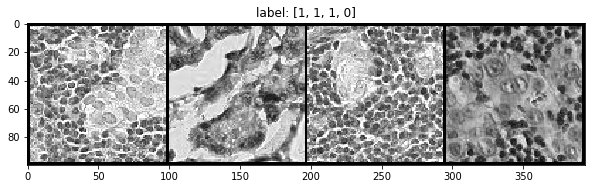

In [66]:
gird_size=4
rnd_inds = np.random.randint(0,len(histo_test),gird_size)
print('image indices:',rnd_inds)

x_grid_test = [histo_test[i][0] for i in range(grid_size)]
y_grid_test = [y_test_pred[i] for i in range(grid_size)]

x_grid_test = utils.make_grid(x_grid_test,nrow=4,padding=2)
print(x_grid_test.shape)

plt.rcParams['figure.figsize'] = (10.0,5)
show(x_grid_test,y_grid_test)